In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs
using ClusterValidityIndices
using MultivariateStats
using KernelDensity
using NetworkLayout
using TravelingSalesmanExact, GLPK

using Memoization
using SparseArrays

using Base.Threads
using Base.Threads: @spawn

┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception = (LoadError("C:\\Users\\Harry\\.julia\\packages\\Plots\\qgrW8\\src\\backends\\unicodeplots.jl", 277, LoadError("C:\\Users\\Harry\\.julia\\packages\\Plots\\qgrW8\\src\\backends\\unicodeplots.jl", 315, UndefVarError(:FileIO))), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000065404881, Ptr{Nothing} @0x0000000065439b2b, Ptr{Nothing} @0x000000006545b3b3, Ptr{Nothing} @0x000000006545a00a, Ptr{Nothing} @0x000000006545b2d7, Ptr{Nothing} @0x000000006545a00a, Ptr{Nothing} @0x00000000654221b5, Ptr{Nothing} @0x0000000065425771, Ptr{Nothing} @0x00000000654253c6, Ptr{Nothing} @0x00000000654253c6, Ptr{Nothing} @0x00000000654253c6, Ptr{Nothing} @0x00000000654253c6, Ptr{Nothing} @0x00000000654253c6, Ptr{Nothing} @0x00000000654253c6, Ptr{Nothing} @0x00000000654253c6, Ptr{Nothing} @0x000000006542821a, Ptr{Nothing} @0x000000006545a0f2, Ptr{Nothing} @0x000000006545a931, Ptr{Nothing} @0x000000006545ba2f, Ptr{Nothing} @0x00

In [3]:
mutable struct LocalLandscape
    origin :: Individual    
    origin_fitness :: Union{Float64,Nothing}
    sample_points :: Union{StepRangeLen,Nothing}
    slice_fitnesses :: Union{Array{Float64, 3},Nothing}
    slice_phenotypes :: Union{Array{Tuple{Float64,Float64}, 3},Nothing}
    transition_prob :: Union{Array{Float64, 2},Nothing}
    debug ::Any
end


function LocalLandscape(start_network::Matrix{Float64},grn_parameters::GRNParameters,development::DESystemSolver)

    p = (start_network,grn_parameters.degradation)

    genotype = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)
    phenotype  = solve(genotype,development.alg;development.kwargs...)

    origin = Individual(genotype,phenotype)

    origin_fitness,origin_pheno_class = fitness_function(origin.phenotype) 
    
    LocalLandscape(origin,origin_fitness,nothing,nothing,nothing,nothing,nothing)

end

function create_mutant_get_pheno(founder::Individual,development::DESystemSolver,entry::Tuple{Int,Int},step::Float64,fitness_function,noise_application)

    mutant = create_mutant(founder,x->increment_weight(entry,step,x,noise_application),development)

    mutant_fitness,mutant_pheno_class = fitness_function(mutant.phenotype)

    return mutant_fitness

end

function increment_weight(entry::Tuple{Int,Int},step::Float64,w::Matrix{Float64},noise_application)
    new_w = copy(w)
    new_w[entry...] = noise_application(new_w[entry...],step)
    return new_w
end

function compute_slices!(LL::LocalLandscape,range_percentile::Float64,N_sample::Int64,development::DESystemSolver,mutation_op::MutationOperator,fitness_function,noise_application)

    start_stop = quantile.(mutation_op.noise_distribution, [1-range_percentile, range_percentile])

    sample_points = range(start_stop[1],start_stop[2],length = N_sample)

    slice_fitnesses = fill(0.,(size(LL.origin.genotype.p[1])...,N_sample))
    
    @sync for i in 1:size(LL.origin.genotype.p[1],1)
        for j in 1:size(LL.origin.genotype.p[1],2) 
            for s in 1:N_sample
                @spawn slice_fitnesses[i,j,s] = create_mutant_get_pheno(LL.origin,development,(i,j),sample_points[s],fitness_function,noise_application)
            end
        end
    end

    LL.sample_points = sample_points
    LL.slice_fitnesses = slice_fitnesses

end

function calculate_fitness_increase_probability(fitness_slice::Vector{Float64},current_fitness::Float64,sample_points::StepRangeLen,mutation_op::MutationOperator,β::Float64)

    mass = 0.

    dx = step(sample_points)

    for i in 1:length(sample_points)
        Δf = fitness_slice[i] - current_fitness 
        mass+= (cdf(mutation_op.noise_distribution,sample_points[i] + dx/2) - cdf(mutation_op.noise_distribution,sample_points[i] - dx/2))*fixation_probability(Δf,β)
    end

    return mass
end


function calculate_transition_probabilities!(LL::LocalLandscape,mutation_op::MutationOperator,β::Float64)

    prob = mapslices(s->calculate_fitness_increase_probability(s,LL.origin_fitness,LL.sample_points,mutation_op,β),LL.slice_fitnesses,dims = 3)[:,:,1]

    LL.transition_prob = prob 
end

function calculate_transition_probabilities(LL::LocalLandscape,mutation_op::MutationOperator,β::Float64)

    prob = mapslices(s->calculate_fitness_increase_probability(s,LL.origin_fitness,LL.sample_points,mutation_op,β),LL.slice_fitnesses,dims = 3)[:,:,1]

    return prob
end
    
@memoize Dict function LocalLandscape(start_network::Matrix{Float64},range_percentile::Float64,N_sample::Int,grn_parameters::GRNParameters,development::DESystemSolver,mutation_op::MutationOperator,β::Float64,fitness_function,noise_application)

    print("Calculating Loss Landscape...")
    
    LL = LocalLandscape(start_network,grn_parameters,development)

    compute_slices!(LL,range_percentile,N_sample,development,mutation_op,fitness_function,noise_application)

    calculate_transition_probabilities!(LL,mutation_op,β)

    LL

end

function LocalLandscape_mass(start_network::Matrix{Float64},range_percentile::Float64,N_sample::Int,grn_parameters::GRNParameters,development::DESystemSolver,mutation_op::MutationOperator,β::Float64,fitness_function,noise_application)
    
    LL = LocalLandscape(start_network,grn_parameters,development)

    compute_slices!(LL,range_percentile,N_sample,development,mutation_op,fitness_function,noise_application)

    calculate_transition_probabilities!(LL,mutation_op,β)

    LL

end

LocalLandscape_mass (generic function with 1 method)

In [4]:
function refresh_type(v)
    [i for i in v]
end

mutable struct GenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    traj :: Vector{Vector{Matrix{Float64}}}

    geno_traj :: Vector{Matrix{Float64}}

    initial_fitness :: Float64
    initial_genotype :: Vector{Float64}

    full_geno_traj :: Union{Vector{Matrix{Float64}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    fgt_data :: Union{Matrix{Float64},Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}

    debug ::Any
end

function GenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[1],et.fitness_trajectory)),evo_traces)
    geno_traj = map(et->reduce(hcat,map(x->vec(x),et.traversed_topologies)),evo_traces);

    traj = map(et->unique(et.traversed_topologies),evo_traces);

    initial_fitness = fitness_traj[1][1]
    initial_genotype = vec(evo_traces[1].traversed_topologies[1])

    GenoTrajectories(fitness_traj,traj,geno_traj,initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)

end

function select_marker(edge_value)
    edge_value > 0 ? :ltriangle : :vline
end

function draw_grn(network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.03, -0.05],
                [0.01, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    f, ax, p = graphplot(ng,layout = fixed_layout,node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]))

    p.elabels_rotation[] = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng))

    # offsets = 0.05 * (p[:node_pos][] .- p[:node_pos][][1])
    p.nlabels_offset[] = offsets

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)

    f,ax,p
end

function draw_grn!(ax,network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.075, -0.05],
                [0.025, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    graphplot!(ax,ng,layout = fixed_layout, node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]), elabels_rotation = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng)),nlabels_offset = offsets)

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)
end

draw_grn! (generic function with 1 method)

In [5]:
save_figs = false

false

In [8]:
evo_traces_cl = load(datadir("sims/repeated_evolution_different_topologies","deletion_prob=0.05_max_gen=40000_mut_prob=0.1_n_target_stripe=1_n_traj=5000_noise_cv=0.5_start_network_name=half_right_topology=classical_β=1.0_1000.jld2"))["data"]
evo_traces_ff = load(datadir("sims/repeated_evolution_different_topologies","deletion_prob=0.05_max_gen=30000_mut_prob=0.1_n_target_stripe=1_n_traj=2000_noise_cv=0.5_start_network_name=half_right_topology=feed_forward_β=1.0_1000.jld2"))["data"]
evo_traces_mi = load(datadir("sims/repeated_evolution_different_topologies","deletion_prob=0.05_max_gen=40000_mut_prob=0.1_n_target_stripe=1_n_traj=5000_noise_cv=0.5_start_network_name=half_right_topology=mutual_inh_β=1.0_1000.jld2"))["data"];

In [9]:
gt_cl = GenoTrajectories(evo_traces_cl);
gt_ff = GenoTrajectories(evo_traces_ff);
gt_mi = GenoTrajectories(evo_traces_mi);

start_network_cl = reshape(gt_cl.initial_genotype,(3,4))
start_network_ff = reshape(gt_ff.initial_genotype,(3,4))
start_network_mi = reshape(gt_mi.initial_genotype,(3,4))

end_fitness_cl = map(x->x[end],gt_cl.fitness_traj);
end_fitness_ff = map(x->x[end],gt_ff.fitness_traj);
end_fitness_mi = map(x->x[end],gt_mi.fitness_traj);

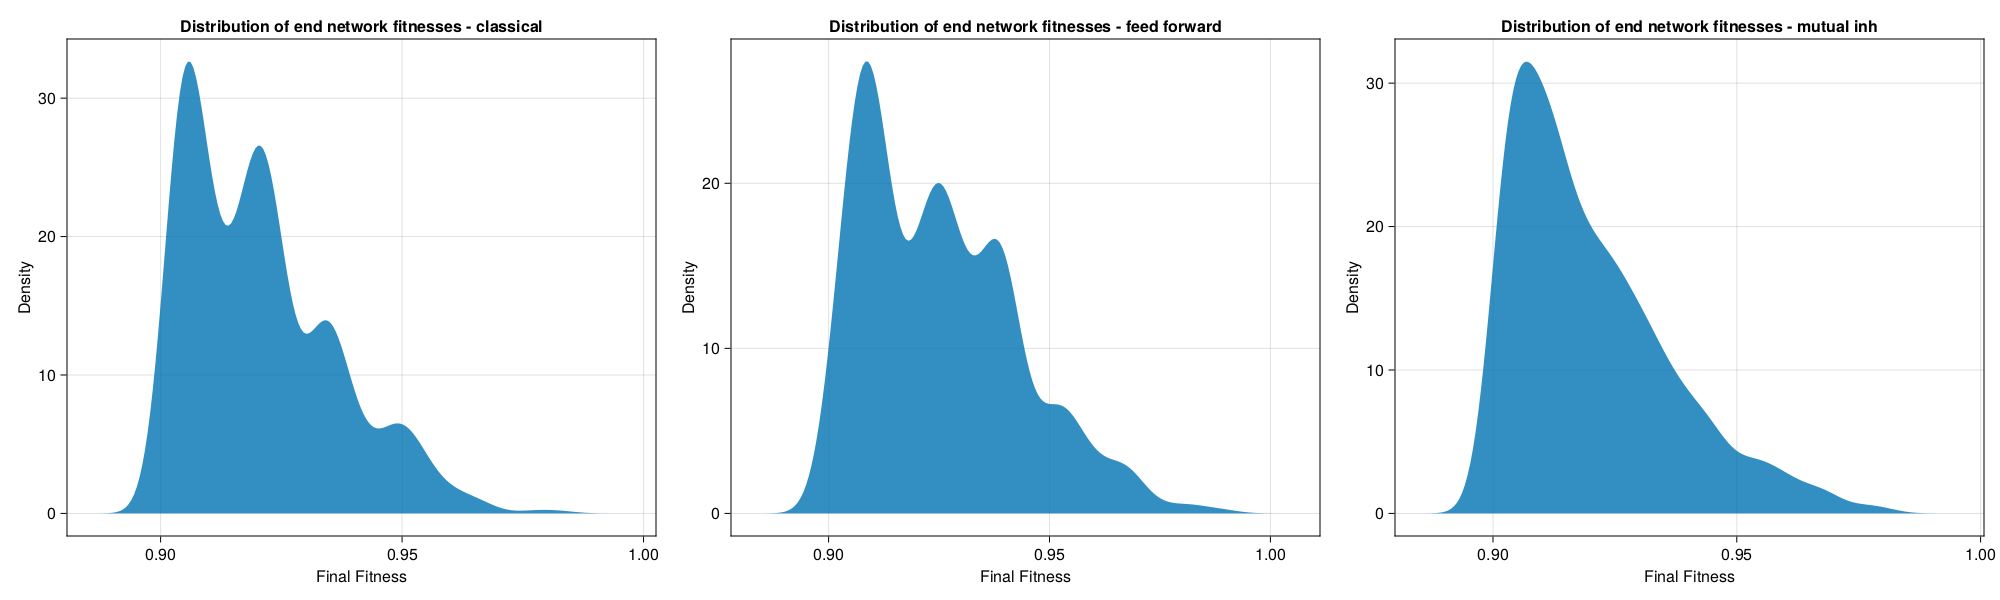

In [10]:
fig = CairoMakie.Figure(resolution = (2000,600))
ax = Axis(fig[1,1],xlabel = "Final Fitness",ylabel = "Density", title = "Distribution of end network fitnesses - classical")
CairoMakie.density!(ax,end_fitness_cl)

ax = Axis(fig[1,2],xlabel = "Final Fitness",ylabel = "Density", title = "Distribution of end network fitnesses - feed forward")
CairoMakie.density!(ax,end_fitness_ff)

ax = Axis(fig[1,3],xlabel = "Final Fitness",ylabel = "Density", title = "Distribution of end network fitnesses - mutual inh")
CairoMakie.density!(ax,end_fitness_mi)

if save_figs
    CairoMakie.save(plotsdir("GraphAnalysis","EndFitnesses.png"),fig)
end

fig

In [11]:
converged_cl = end_fitness_cl .> 0.9

sum(end_fitness_cl .> 0.9)

1000

In [12]:
converged_ff = end_fitness_ff .> 0.9

sum(end_fitness_ff .> 0.9)

1000

In [13]:
converged_mi = end_fitness_mi .> 0.9

sum(end_fitness_mi .> 0.9)
a

1000

In [14]:
# itp_g = DataInterpolations.LinearInterpolation(unique_geno_visits[:,2],fitness_timestamps);
# full_weight_traj[wi,:] = [itp_g(t) for t in gt.initial_fitness:n:0]

mutable struct InterpolatedLandscape
    origin :: Individual    
    origin_fitness :: Union{Float64,Nothing}
    n_interp :: Union{Int64,Nothing}
    itp_networks :: Union{Array{Float64, 2},Nothing}
    slice_fitnesses :: Union{Array{Float64, 1},Nothing}
    debug ::Any
end

function InterpolatedLandscape(start_network_v::Vector{Float64},end_network_v::Vector{Float64},n_interp::Int64,grn_parameters::GRNParameters,development::DESystemSolver)

    start_network = reshape(start_network_v,(3,4))

    end_network = reshape(end_network_v,(3,4))

    p = (start_network,grn_parameters.degradation)

    genotype = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)
    phenotype  = solve(genotype,development.alg;development.kwargs...)

    origin = Individual(genotype,phenotype)

    origin_fitness,origin_pheno_class = fitness_function(origin.phenotype) 

    ######

    start_end = hcat(start_network_v,end_network_v)

    itp_networks = zeros(size(start_end,1),n_interp)

    for wi in 1:size(start_end,1)
        itp_g = DataInterpolations.LinearInterpolation(start_end[wi,:],[1,n_interp]);
        itp_networks[wi,:] = [itp_g(t) for t in 1:1:n_interp]
    end

    ######

    slice_fitnesses = zeros(n_interp)

    for (n,network) in enumerate(eachcol(itp_networks))

        if n == 1
            slice_fitnesses[n] = origin_fitness
        else
            new_w = reshape(network,(3,4))
            
            mutant = Individual(remake(origin.genotype, p = (new_w,origin.genotype.p[2:end]...)),development)

            if mutant.phenotype.retcode == :Terminated
                mutant_fitness,mutant_pheno_class = fitness_function(mutant.phenotype)
            else
                mutant_fitness = -1.
            end

            slice_fitnesses[n] = mutant_fitness
        end
    end

    # end_fitness = slice_fitnesses[end]

    # instability = minimum(slice_fitnesses) - 0.5*(origin_fitness+start_fitness)

    InterpolatedLandscape(origin,origin_fitness,n_interp,itp_networks,slice_fitnesses,nothing)

end

InterpolatedLandscape

In [15]:
function mutate_method(x,n)

    max_w = 1.
    if x == 0
        proposal = x + n
        r = abs(proposal) > max_w ? max_w*sign(proposal) : proposal
    else
        proposal = x + n*x
        r = abs(proposal) > max_w ? max_w*sign(proposal) : proposal
    end

    return r
end

grn_parameters = DefaultGRNParameters();

development = DefaultGRNSolver()

viable_mutations = ones(Int,Ng,Ng+1)

noise_cv = 0.5

mutation_op = MutationOperator(Normal,(μ = 0.0,σ = noise_cv),findall(viable_mutations .> 0))

n_sample_func() = 1

deletion_prob = 0.05

noise_params = (n_sample_func,deletion_prob)

mutate_function = i -> noise(i,mutation_op,noise_params);

noise_application = (x,n) -> mutate_method(x,n)

output_gene = 3

n_target_stripe = 1

fitness_function = s -> fitness_evaluation(s,x->malt_fitness(x,n_target_stripe),output_gene);

In [16]:
itp_ll = InterpolatedLandscape(gt_cl.geno_traj[2][:,end],gt_cl.geno_traj[3][:,end],30,grn_parameters,development);

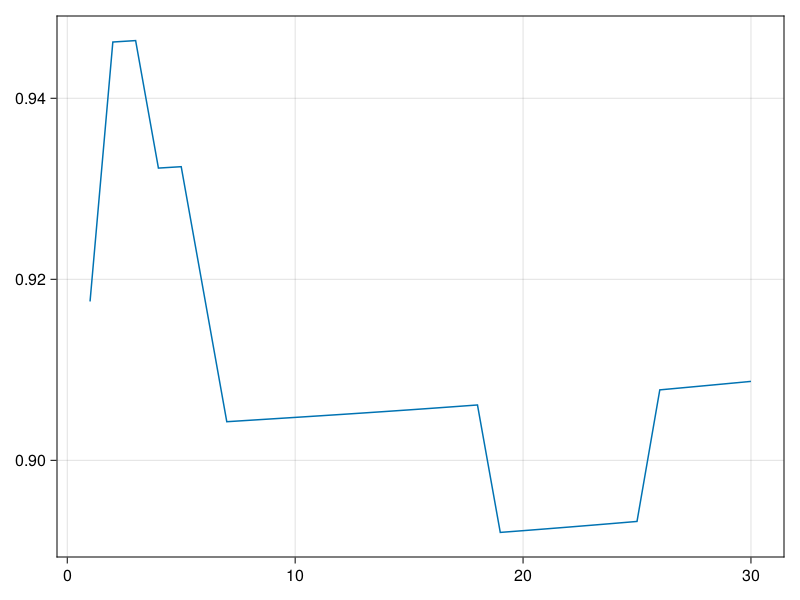

In [17]:
CairoMakie.lines(itp_ll.slice_fitnesses)

In [18]:
0.5*(itp_ll.slice_fitnesses[1] + itp_ll.slice_fitnesses[end] + 2) - minimum(itp_ll.slice_fitnesses .+ 1)

0.021099784449324366

In [19]:
function instability(network_1,network_2,grn_parameters,development)

    itp_ll = InterpolatedLandscape(network_1,network_2,30,grn_parameters,development);

    return 0.5*(itp_ll.slice_fitnesses[1] + itp_ll.slice_fitnesses[end] + 2) - minimum(itp_ll.slice_fitnesses .+ 1)

end


instability (generic function with 1 method)

In [20]:
instability(gt_cl.geno_traj[2][:,end],gt_cl.geno_traj[3][:,end], grn_parameters,development)

0.021099784449324366

In [21]:
end_networks_cl = map(x->x[:,end],gt_cl.geno_traj);
end_networks_ff = map(x->x[:,end],gt_ff.geno_traj);
end_networks_mi = map(x->x[:,end],gt_mi.geno_traj);

all_networks = reduce(vcat,[end_networks_cl,end_networks_ff,end_networks_mi]);

In [22]:
label_cl = [1 for n in end_networks_cl]
label_ff = [2 for n in end_networks_ff]
label_mi = [3 for n in end_networks_mi]

all_labels = reduce(vcat,[label_cl,label_ff,label_mi]);

In [24]:
n_sample = length(all_networks)

dmat = zeros(n_sample,n_sample)

@sync for i in 1:n_sample
    for j in 1:n_sample
        if i>j
            @spawn dmat[i,j] = instability(all_networks[i],all_networks[j],grn_parameters,development)
        end
    end
end

for i in 1:n_sample
    for j in 1:n_sample
        if i<j
            dmat[i,j] = dmat[j,i]
        end
    end
end

for i in 1:n_sample
    dmat[i,i] = 0.
end


In [ ]:
save(datadir("sims/repeated_evolution_different_topologies","pairwise_instabilities_mi_cl_ff_3000.jld2"),"data",dmat)

In [ ]:
thresh = 0.05

dmat_c = zeros(Int64,size(dmat))

dmat_c[dmat .< thresh] .= 1
 
for i in 1:n_sample
    dmat_c[i,i] = 0
end


In [ ]:
g_fit = SimpleGraph(dmat_c)

is_connected(g_fit)

In [ ]:
con_comp = connected_components(g_fit)

map(x->length(x),con_comp)

In [ ]:
graphplot(g_fit)

In [ ]:
tour, cost = get_optimal_tour(dmat_c)

In [ ]:
tour_route = [(tour[i],tour[i+1]) for i in 1:length(tour)-1]

cost_route = [dmat[(i,j)...] for  (i,j) in tour_route]

maximum(cost_route)

In [ ]:
hc = hclust(dmat,linkage = :complete)

In [ ]:
StatsPlots.plot(hc)

In [ ]:
unique(cutree(hc,h = 0.5))

In [ ]:
function is_monotonic_increasing(slice)

    all((slice[2:end] .- slice[1:end-1]) .>= 0)
end



In [ ]:
fig = CairoMakie.Figure(resolution = (1000,1000))
ax = Axis(fig[1,1])

include_traj = map(x->x[end] > 0.55,gt.fitness_traj);

for int_ll in all_int_ll[include_traj]
    CairoMakie.lines!(ax,int_ll.slice_fitnesses)
end

fig